In [1]:
import sys
sys.path.insert(0,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos')
sys.path.insert(1,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github')
import numpy as np
import pandas as pd
import xarray as xr

import wandb
import xgboost as xgb
import re

from importlib import reload

# Import Omphalos modules.
from omphalos import file_methods as fm
from omphalos import attributes as attr
from omphalos import labels as lbls
from analysis import helper as hp

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d

random_state = 69
np.random.state = random_state
np.random.seed = random_state

/Users/thomasdodd/opt/anaconda3/envs/omphalos/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Training Data Import & Cleaning

In [2]:
# Define all the attributes we have varied in .yaml file
attribute_names = ["Al+++","Ca++","Fe++","K+","Na+","Mg++","SiO2(aq)","Cl-"]

In [3]:
# Port in and unpack all the runs we need from the .pkl file.
TrainSet_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_32000runs/completed_run.pkl')

In [4]:
# Filter all errored files out of the dictionary
dataset_dict, error_dict = hp.filter_errors(TrainSet_dict)

Returned 27509 files without errors out of a total possible 32000.
4491 files had errors.
0 files had unhandled errors.
File failure rate: 16.32556617834163 %.
To see unhandled errors, run with verbose=True.


In [5]:
# Get a df of all the start attributes of interest
attributes_all_df = attr.get_condition(dataset_dict,"f_i_onehundred",species_concs=True)
attributes_all_df = attributes_all_df.loc[:, attribute_names]
attributes_all_df

/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)


,Al+++,Ca++,Fe++,K+,Na+,Mg++,SiO2(aq),Cl-
0,0.016153,0.016134,0.012228,0.018647,0.016275,0.017318,0.003776,0.016377
1,0.003152,0.013060,0.013292,0.013327,0.012281,0.013464,0.007094,0.002883
2,0.010019,0.018628,0.000623,0.004058,0.019369,0.018086,0.014039,0.009710
3,0.011326,0.012745,0.002625,0.011348,0.000538,0.014791,0.010975,0.012746
4,0.006303,0.010286,0.002111,0.017350,0.012449,0.019303,0.002528,0.018715
...,...,...,...,...,...,...,...,...
27504,0.010794,0.008441,0.018678,0.008334,0.015491,0.010218,0.018763,0.007174
27505,0.015221,0.018727,0.004800,0.005948,0.011802,0.010917,0.014930,0.007451
27506,0.014366,0.008698,0.004591,0.003868,0.000819,0.011543,0.014164,0.005451
27507,0.001577,0.001195,0.003691,0.018730,0.008866,0.004941,0.016075,0.009608


In [6]:
# Get an array of the end carbonate volumes generated
NonCalSidMag_arr = ["Diopside","Diopside_a","Hedenbergite","Hedenbergite_a",
                    "Albite","Albite_a","Anorthite","Anorthite_a","M_Microcline",
                    "M_Microcline_a","M_Microcline_b","Forsterite","Forsterite_a",
                    "Fayalite","Fayalite_a","Antigorite","Antigorite_a","Greenalite",
                    "Greenalite_a","Calcite_a","Siderite_a","Magnesite_a"]
CalSidMag_arr = ["Calcite","Siderite","Magnesite"]

Vols_ds = lbls.raw(dataset_dict, 'volume')
NrXDiscretisedBlocks = len(Vols_ds.X.values)
EndVols_ds = Vols_ds.sel(time=280.0)
CalSidMagEndVols_ds = EndVols_ds.drop(labels=NonCalSidMag_arr)

CalSidMagEndVols_da = CalSidMagEndVols_ds.to_array(dim='arbitrary_array')
CalSidMagEndVols_da = CalSidMagEndVols_da.astype(str)
CalSidMagEndVols_da = CalSidMagEndVols_da.str.replace("^\d+\.\d+-\d+$", "0", regex=True)
CalSidMagEndVols_da = CalSidMagEndVols_da.str.replace("^\d+\.\d+\+\d+$", "5000.0000", regex=True)
CalSidMagEndVols_da = CalSidMagEndVols_da.astype(float)

CalSidMagEndVols_ds = CalSidMagEndVols_da.to_dataset(dim="arbitrary_array")
SpatialSummedCalSidMagEndVols_ds = CalSidMagEndVols_ds.sum(dim=["X","Y","Z"])
SpatialSummedCarbEndVols_ds = SpatialSummedCalSidMagEndVols_ds.assign(Carbonates=lambda SpatialSummedCalSidMagEndVols_ds: SpatialSummedCalSidMagEndVols_ds.Calcite + SpatialSummedCalSidMagEndVols_ds.Siderite + SpatialSummedCalSidMagEndVols_ds.Magnesite)
SpatialSummedCarbEndVols_ds = SpatialSummedCarbEndVols_ds.drop(labels=CalSidMag_arr)
SpatialSummedCarbEndVols_arr = np.array(SpatialSummedCarbEndVols_ds.Carbonates.values)
attributes_all_df["Carbonates_sum"] = SpatialSummedCarbEndVols_arr.tolist()
attributes_all_df

,Al+++,Ca++,Fe++,K+,Na+,Mg++,SiO2(aq),Cl-,Carbonates_sum
0,0.016153,0.016134,0.012228,0.018647,0.016275,0.017318,0.003776,0.016377,1.672473
1,0.003152,0.013060,0.013292,0.013327,0.012281,0.013464,0.007094,0.002883,1.876084
2,0.010019,0.018628,0.000623,0.004058,0.019369,0.018086,0.014039,0.009710,1.273991
3,0.011326,0.012745,0.002625,0.011348,0.000538,0.014791,0.010975,0.012746,1.234340
4,0.006303,0.010286,0.002111,0.017350,0.012449,0.019303,0.002528,0.018715,2.290114
...,...,...,...,...,...,...,...,...,...
27504,0.010794,0.008441,0.018678,0.008334,0.015491,0.010218,0.018763,0.007174,1.115855
27505,0.015221,0.018727,0.004800,0.005948,0.011802,0.010917,0.014930,0.007451,1.057754
27506,0.014366,0.008698,0.004591,0.003868,0.000819,0.011543,0.014164,0.005451,1.090099
27507,0.001577,0.001195,0.003691,0.018730,0.008866,0.004941,0.016075,0.009608,2.235406


In [7]:

attributes_cleaned_df = attributes_all_df
attributes_cleaned_df.loc[attributes_cleaned_df['Carbonates_sum'] > (1*NrXDiscretisedBlocks), 'Carbonates_sum'] = np.nan
attributes_cleaned_df.loc[attributes_cleaned_df['Carbonates_sum'] == np.inf, 'Carbonates_sum'] = np.nan
attributes_cleaned_df = attributes_cleaned_df.dropna()
attributes_cleaned_df = attributes_cleaned_df.reset_index(drop=True)
attributes_cleaned_df["Carbonates_avg"] = (attributes_cleaned_df["Carbonates_sum"] / NrXDiscretisedBlocks)
attributes_cleaned_df["Carbonates_pct"] = (attributes_cleaned_df["Carbonates_avg"] / 1) * 100
attributes_cleaned_df = attributes_cleaned_df.drop(['Carbonates_sum', 'Carbonates_avg'], axis=1)
attributes_cleaned_df

,Al+++,Ca++,Fe++,K+,Na+,Mg++,SiO2(aq),Cl-,Carbonates_pct
0,0.016153,0.016134,0.012228,0.018647,0.016275,0.017318,0.003776,0.016377,1.100311
1,0.003152,0.013060,0.013292,0.013327,0.012281,0.013464,0.007094,0.002883,1.234266
2,0.010019,0.018628,0.000623,0.004058,0.019369,0.018086,0.014039,0.009710,0.838152
3,0.011326,0.012745,0.002625,0.011348,0.000538,0.014791,0.010975,0.012746,0.812066
4,0.006303,0.010286,0.002111,0.017350,0.012449,0.019303,0.002528,0.018715,1.506654
...,...,...,...,...,...,...,...,...,...
27479,0.010794,0.008441,0.018678,0.008334,0.015491,0.010218,0.018763,0.007174,0.734115
27480,0.015221,0.018727,0.004800,0.005948,0.011802,0.010917,0.014930,0.007451,0.695891
27481,0.014366,0.008698,0.004591,0.003868,0.000819,0.011543,0.014164,0.005451,0.717170
27482,0.001577,0.001195,0.003691,0.018730,0.008866,0.004941,0.016075,0.009608,1.470662


# XGBoost Model Training

In [8]:
# Split the ML datasets into x's (predictor arrays) and y's (target arrays)
x = attributes_cleaned_df.loc[:, attribute_names].astype(float)
y = attributes_cleaned_df["Carbonates_pct"].values.astype(float)

# Generate a numpy matrix from a pandas dataframe
x = x.to_numpy()

# Normalisation array for each of the columns in x
# Essentially the top values that are found in each of these columns
x_norms = []
for _ in attribute_names:
    max_val = max(attributes_cleaned_df[_].values)
    x_norms.append(max_val)
    print(f"Normalisation Factor for {_} = {max_val}")

# Normalisation of the np matrix using the x_norm array
for i, norm in enumerate(x_norms):
    x[:, i] = x[:, i]/norm

# Generate a vertical array of target values.
y = y.reshape(-1,1)
# y = y * 1e4 ?? Is this normalisation Angus? If so, I'd have done it like this:
y_norm = max(y)
print(f"Normalisation Factor for Carbonate Volume Generated = {y_norm}")
y = y / y_norm

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=random_state)

Normalisation Factor for Al+++ = 0.0199996777771118
Normalisation Factor for Ca++ = 0.0199998101672167
Normalisation Factor for Fe++ = 0.019999719657439
Normalisation Factor for K+ = 0.019999945896381
Normalisation Factor for Na+ = 0.0199997455006281
Normalisation Factor for Mg++ = 0.0199994907051103
Normalisation Factor for SiO2(aq) = 0.0199990220873342
Normalisation Factor for Cl- = 0.0199997402413945
Normalisation Factor for Carbonate Volume Generated = [96.2359084]


In [9]:
%%time

xgb_defaults = {
    'tree_method': 'hist',
    'gamma': 0,
    'mds': 0,
    'eta': 0.01,
    'l1' : 0,
    'l2' : 1,
    'max_depth' : 0,
    'max_leaves': 6,
    'objective': 'reg:squarederror',
    'max_bin': 10000,
    'grow_policy': 'lossguide'
}

# Initialise the wandb instance
wandb.init(config=xgb_defaults, project='bfm_5-5')

# Setup xgb matrices; one for training and one testing
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

evallist = [(dtest, 'eval'), (dtrain, 'train')]

params = {'max_depth': wandb.config.max_depth,
            'tree_method': wandb.config.tree_method,
            'max_delta_step': wandb.config.mds,
            'eta': wandb.config.eta,
            'objective': wandb.config.objective,
            'alpha': wandb.config.l1,
            'lambda': wandb.config.l2,
            'gamma': wandb.config.gamma,
            'max_leaves': wandb.config.max_leaves,
            'max_bin': wandb.config.max_bin,
            'grow_policy': wandb.config.grow_policy
        }

results = {}

num_round = 300000
bst = xgb.train(params, dtrain, num_round, evallist, evals_result=results, verbose_eval=False, callbacks=[wandb.xgboost.WandbCallback()])
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tjhd97. Use `wandb login --relogin` to force relogin


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval-rmse,▁▁▁▂▂▃▃▃▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████
train-rmse,██▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
epoch,299999


CPU times: user 3h 9min 33s, sys: 9min 11s, total: 3h 18min 44s
Wall time: 19min 36s


In [10]:
bst.save_model("bfm_XGBModel_5-5_Epo-300000.json")

# Comparison Data Import and Cleaning

In [11]:
# Port in and unpack all the runs we need from the .pkl file.
CtrlSet_al_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/al/completed_run.pkl')
CtrlSet_ca_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/ca/completed_run.pkl')
CtrlSet_fe_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/fe/completed_run.pkl')
CtrlSet_k_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/k/completed_run.pkl')
CtrlSet_mg_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/mg/completed_run.pkl')
CtrlSet_na_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/na/completed_run.pkl')
CtrlSet_si_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/si/completed_run.pkl')
CtrlSet_cl_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/cl/completed_run.pkl')

In [12]:
# Create a number of datasets from the control RTM experiments
dataset_al_dict, error_dict = hp.filter_errors(CtrlSet_al_dict)
dataset_ca_dict, error_dict = hp.filter_errors(CtrlSet_ca_dict)
dataset_fe_dict, error_dict = hp.filter_errors(CtrlSet_fe_dict)
dataset_k_dict, error_dict = hp.filter_errors(CtrlSet_k_dict)
dataset_mg_dict, error_dict = hp.filter_errors(CtrlSet_mg_dict)
dataset_na_dict, error_dict = hp.filter_errors(CtrlSet_na_dict)
dataset_si_dict, error_dict = hp.filter_errors(CtrlSet_si_dict)
dataset_cl_dict, error_dict = hp.filter_errors(CtrlSet_cl_dict)

Returned 170 files without errors out of a total possible 200.
30 files had errors.
0 files had unhandled errors.
File failure rate: 17.647058823529413 %.
To see unhandled errors, run with verbose=True.
Returned 197 files without errors out of a total possible 200.
3 files had errors.
0 files had unhandled errors.
File failure rate: 1.5228426395939088 %.
To see unhandled errors, run with verbose=True.
Returned 199 files without errors out of a total possible 200.
1 files had errors.
0 files had unhandled errors.
File failure rate: 0.5025125628140703 %.
To see unhandled errors, run with verbose=True.
Returned 197 files without errors out of a total possible 200.
3 files had errors.
0 files had unhandled errors.
File failure rate: 1.5228426395939088 %.
To see unhandled errors, run with verbose=True.
Returned 199 files without errors out of a total possible 199.
0 files had errors.
0 files had unhandled errors.
File failure rate: 0.0 %.
To see unhandled errors, run with verbose=True.
Retu

In [13]:
# Get all the attribute df's for the control RTM experiments
attributes_al_df = attr.get_condition(dataset_al_dict,"f_i_onehundred",species_concs=True)
attributes_al_df = attributes_al_df.loc[:, attribute_names]
attributes_ca_df = attr.get_condition(dataset_ca_dict,"f_i_onehundred",species_concs=True)
attributes_ca_df = attributes_ca_df.loc[:, attribute_names]
attributes_fe_df = attr.get_condition(dataset_fe_dict,"f_i_onehundred",species_concs=True)
attributes_fe_df = attributes_fe_df.loc[:, attribute_names]
attributes_k_df = attr.get_condition(dataset_k_dict,"f_i_onehundred",species_concs=True)
attributes_k_df = attributes_k_df.loc[:, attribute_names]
attributes_mg_df = attr.get_condition(dataset_mg_dict,"f_i_onehundred",species_concs=True)
attributes_mg_df = attributes_mg_df.loc[:, attribute_names]
attributes_na_df = attr.get_condition(dataset_na_dict,"f_i_onehundred",species_concs=True)
attributes_na_df = attributes_na_df.loc[:, attribute_names]
attributes_si_df = attr.get_condition(dataset_si_dict,"f_i_onehundred",species_concs=True)
attributes_si_df = attributes_si_df.loc[:, attribute_names]
attributes_cl_df = attr.get_condition(dataset_cl_dict,"f_i_onehundred",species_concs=True)
attributes_cl_df = attributes_cl_df.loc[:, attribute_names]

/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)
/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)
/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary

In [14]:
def ControlData_CarbonateArrayRetriever(dataset_dictionary,attributes_df):
    Vols_ds = lbls.raw(dataset_dictionary, 'volume')
    NrXDiscretisedBlocks = len(Vols_ds.X.values)
    EndVols_ds = Vols_ds.sel(time=280.0)
    CalSidMagEndVols_ds = EndVols_ds.drop(labels=NonCalSidMag_arr)

    CalSidMagEndVols_da = CalSidMagEndVols_ds.to_array(dim='arbitrary_array')
    CalSidMagEndVols_da = CalSidMagEndVols_da.astype(str)
    CalSidMagEndVols_da = CalSidMagEndVols_da.str.replace("^\d+\.\d+-\d+$", "0", regex=True)
    CalSidMagEndVols_da = CalSidMagEndVols_da.str.replace("^\d+\.\d+\+\d+$", "5000.0000", regex=True)
    CalSidMagEndVols_da = CalSidMagEndVols_da.astype(float)

    CalSidMagEndVols_ds = CalSidMagEndVols_da.to_dataset(dim="arbitrary_array")
    SpatialSummedCalSidMagEndVols_ds = CalSidMagEndVols_ds.sum(dim=["X","Y","Z"])
    SpatialSummedCarbEndVols_ds = SpatialSummedCalSidMagEndVols_ds.assign(Carbonates=lambda SpatialSummedCalSidMagEndVols_ds: SpatialSummedCalSidMagEndVols_ds.Calcite + SpatialSummedCalSidMagEndVols_ds.Siderite + SpatialSummedCalSidMagEndVols_ds.Magnesite)
    SpatialSummedCarbEndVols_arr = np.array(SpatialSummedCarbEndVols_ds.Carbonates.values)
    attributes_df['Carbonates_sum'] = SpatialSummedCarbEndVols_arr.tolist()

    attributes_df.loc[attributes_df['Carbonates_sum'] > (1*NrXDiscretisedBlocks), 'Carbonates_sum'] = np.nan
    attributes_df.loc[attributes_df['Carbonates_sum'] == np.inf, 'Carbonates_sum'] = np.nan
    attributes_df = attributes_df.dropna()
    attributes_df = attributes_df.reset_index(drop=True)
    attributes_df["Carbonates_avg"] = (attributes_df["Carbonates_sum"] / NrXDiscretisedBlocks)
    attributes_df["Carbonates_pct"] = (attributes_df["Carbonates_avg"] / 1) * 100
    CarbonatePct_arr = np.array(attributes_df["Carbonates_pct"])

    return CarbonatePct_arr, attributes_df

In [15]:
# Retrieval of xarray datasets containing final and initial mineralogical volume fractions for the control RTM experiments
CarbonatePct_al_arr,attributes_al_df = ControlData_CarbonateArrayRetriever(dataset_al_dict,attributes_al_df)
CarbonatePct_ca_arr,attributes_ca_df = ControlData_CarbonateArrayRetriever(dataset_ca_dict,attributes_ca_df)
CarbonatePct_fe_arr,attributes_fe_df = ControlData_CarbonateArrayRetriever(dataset_fe_dict,attributes_fe_df)
CarbonatePct_k_arr,attributes_k_df = ControlData_CarbonateArrayRetriever(dataset_k_dict,attributes_k_df)
CarbonatePct_mg_arr,attributes_mg_df = ControlData_CarbonateArrayRetriever(dataset_mg_dict,attributes_mg_df)
CarbonatePct_na_arr,attributes_na_df = ControlData_CarbonateArrayRetriever(dataset_na_dict,attributes_na_df)
CarbonatePct_si_arr,attributes_si_df = ControlData_CarbonateArrayRetriever(dataset_si_dict,attributes_si_df)
CarbonatePct_cl_arr,attributes_cl_df = ControlData_CarbonateArrayRetriever(dataset_cl_dict,attributes_cl_df)

In [16]:
# Control Experiments
# Split the datasets into x's and y's
# Normalise the control x's and y's in the same way as the training data


# Control 1 - Al+++ Varied, Ca++/Fe++/K+/Na+/Mg++/SiO2(aq)/Cl- Held-Steady
x_AlCtrl_matrix = attributes_al_df.loc[:, attribute_names].astype(float)
y_AlCtrl_arr = CarbonatePct_al_arr.astype(float)

x_AlCtrl_matrix = x_AlCtrl_matrix.to_numpy()
x_AlCtrl_norm_matrix = x_AlCtrl_matrix
for i, norm in enumerate(x_norms):
    x_AlCtrl_norm_matrix[:, i] = x_AlCtrl_norm_matrix[:, i]/norm

x_AlCtrl_norm_arr = np.hstack(x_AlCtrl_norm_matrix[:,0])
y_AlCtrl_norm_arr = np.hstack(y_AlCtrl_arr / y_norm) 


# Control 2 - Ca++ Varied, Al+++/Fe++/K+/Na+/Mg++/SiO2(aq)/Cl- Held-Steady
x_CaCtrl_matrix = attributes_ca_df.loc[:, attribute_names].astype(float)
y_CaCtrl_arr = CarbonatePct_ca_arr.astype(float)

x_CaCtrl_matrix = x_CaCtrl_matrix.to_numpy()
x_CaCtrl_norm_matrix = x_CaCtrl_matrix
for i, norm in enumerate(x_norms):
    x_CaCtrl_norm_matrix[:, i] = x_CaCtrl_norm_matrix[:, i]/norm

x_CaCtrl_norm_arr = np.hstack(x_CaCtrl_norm_matrix[:,1])
y_CaCtrl_norm_arr = np.hstack(y_CaCtrl_arr / y_norm)


# Control 3 - Fe++ Varied, Al+++/Ca++/K+/Na+/Mg++/SiO2(aq)/Cl- Held-Steady
x_FeCtrl_matrix = attributes_fe_df.loc[:, attribute_names].astype(float)
y_FeCtrl_arr = CarbonatePct_fe_arr.astype(float)

x_FeCtrl_matrix = x_FeCtrl_matrix.to_numpy()
x_FeCtrl_norm_matrix = x_FeCtrl_matrix
for i, norm in enumerate(x_norms):
    x_FeCtrl_norm_matrix[:, i] = x_FeCtrl_norm_matrix[:, i]/norm

x_FeCtrl_norm_arr = np.hstack(x_FeCtrl_norm_matrix[:,2])
y_FeCtrl_norm_arr = np.hstack(y_FeCtrl_arr / y_norm)


# Control 4 - K+ Varied, Al+++/Ca++/Fe++/Na+/Mg++/SiO2(aq)/Cl- Held-Steady
x_KCtrl_matrix = attributes_k_df.loc[:, attribute_names].astype(float)
y_KCtrl_arr = CarbonatePct_k_arr.astype(float)

x_KCtrl_matrix = x_KCtrl_matrix.to_numpy()
x_KCtrl_norm_matrix = x_KCtrl_matrix
for i, norm in enumerate(x_norms):
    x_KCtrl_norm_matrix[:, i] = x_KCtrl_norm_matrix[:, i]/norm

x_KCtrl_norm_arr = np.hstack(x_KCtrl_norm_matrix[:,3])
y_KCtrl_norm_arr = np.hstack(y_KCtrl_arr / y_norm)


# Control 5 - Na+ Varied, Al+++/Ca++/Fe++/K+/Mg++/SiO2(aq)/Cl- Held-Steady
x_NaCtrl_matrix = attributes_na_df.loc[:, attribute_names].astype(float)
y_NaCtrl_arr = CarbonatePct_na_arr.astype(float)

x_NaCtrl_matrix = x_NaCtrl_matrix.to_numpy()
x_NaCtrl_norm_matrix = x_NaCtrl_matrix
for i, norm in enumerate(x_norms):
    x_NaCtrl_norm_matrix[:, i] = x_NaCtrl_norm_matrix[:, i]/norm

x_NaCtrl_norm_arr = np.hstack(x_NaCtrl_norm_matrix[:,4])
y_NaCtrl_norm_arr = np.hstack(y_NaCtrl_arr / y_norm)


# Control 6 - Mg++ Varied, Al+++/Ca++/Fe++/K+/Na+/SiO2(aq)/Cl- Held-Steady
x_MgCtrl_matrix = attributes_mg_df.loc[:, attribute_names].astype(float)
y_MgCtrl_arr = CarbonatePct_mg_arr.astype(float)

x_MgCtrl_matrix = x_MgCtrl_matrix.to_numpy()
x_MgCtrl_norm_matrix = x_MgCtrl_matrix
for i, norm in enumerate(x_norms):
    x_MgCtrl_norm_matrix[:, i] = x_MgCtrl_norm_matrix[:, i]/norm

x_MgCtrl_norm_arr = np.hstack(x_MgCtrl_norm_matrix[:,5])
y_MgCtrl_norm_arr = np.hstack(y_MgCtrl_arr / y_norm)


# Control 7 - SiO2(aq) Varied, Al+++/Ca++/Fe++/K+/Na+/Mg++/Cl- Held-Steady
x_SiCtrl_matrix = attributes_si_df.loc[:, attribute_names].astype(float)
y_SiCtrl_arr = CarbonatePct_si_arr.astype(float)

x_SiCtrl_matrix = x_SiCtrl_matrix.to_numpy()
x_SiCtrl_norm_matrix = x_SiCtrl_matrix
for i, norm in enumerate(x_norms):
    x_SiCtrl_norm_matrix[:, i] = x_SiCtrl_norm_matrix[:, i]/norm

x_SiCtrl_norm_arr = np.hstack(x_SiCtrl_norm_matrix[:,6])
y_SiCtrl_norm_arr = np.hstack(y_SiCtrl_arr / y_norm)


# Control 8 - Cl- Varied, Al+++/Ca++/Fe++/K+/Na+/Mg++/SiO2(aq) Held-Steady
x_ClCtrl_matrix = attributes_cl_df.loc[:, attribute_names].astype(float)
y_ClCtrl_arr = CarbonatePct_cl_arr.astype(float)

x_ClCtrl_matrix = x_ClCtrl_matrix.to_numpy()
x_ClCtrl_norm_matrix = x_ClCtrl_matrix
for i, norm in enumerate(x_norms):
    x_ClCtrl_norm_matrix[:, i] = x_ClCtrl_norm_matrix[:, i]/norm

x_ClCtrl_norm_arr = np.hstack(x_ClCtrl_norm_matrix[:,7])
y_ClCtrl_norm_arr = np.hstack(y_ClCtrl_arr / y_norm)

In [17]:
def dictionary_maker(k_l, v_l):
    zip_iterator = zip(k_l, v_l)
    new_dictionary = dict(zip_iterator)
    return new_dictionary

In [18]:
def dictarray_retriever(searchDict,attrib):
    find_key = attrib
    res = list(searchDict.keys()).index(find_key)
    values = list(searchDict.items())
    dict_part = values[res]
    return dict_part[1]

In [19]:
attributes_RTMTruth_keys_list = attribute_names
attributes_RTMTruth_values_list = [x_AlCtrl_norm_arr, x_CaCtrl_norm_arr, x_FeCtrl_norm_arr, x_KCtrl_norm_arr, x_NaCtrl_norm_arr, x_MgCtrl_norm_arr, x_SiCtrl_norm_arr, x_ClCtrl_norm_arr]
attributes_RTMTruth_dict = dictionary_maker(attributes_RTMTruth_keys_list,attributes_RTMTruth_values_list)

target_RTMTruth_keys_list = attribute_names
target_RTMTruth_values_list = [y_AlCtrl_norm_arr, y_CaCtrl_norm_arr, y_FeCtrl_norm_arr, y_KCtrl_norm_arr, y_NaCtrl_norm_arr, y_MgCtrl_norm_arr, y_SiCtrl_norm_arr, y_ClCtrl_norm_arr]
target_RTMTruth_dict = dictionary_maker(target_RTMTruth_keys_list,target_RTMTruth_values_list)

# Comparison of RTM Control Experiments (Ground Truth) with XGB Predictions

In [20]:
# Load the XGBoost model trained earlier
bst = xgb.Booster()
bst.load_model(fname='bfm_XGBModel_5-5_Epo-1000000.json')

In [21]:
# Prediction Experiments

# The variable as varied between lower and upper bounds
variable_range_lower, variable_range_upper = 0, 2.0E-2
# The controlled values in the base .in file
yamlcontrolled_al_val = 0.00953981392737719
yamlcontrolled_ca_val = 0.006229012131079079
yamlcontrolled_fe_val = 0.018144146311725996
yamlcontrolled_k_val = 0.017110734975244037
yamlcontrolled_na_val = 0.018215952565736267
yamlcontrolled_mg_val = 0.013919712364785673
yamlcontrolled_si_val = 0.01651024693344055
yamlcontrolled_cl_val = 0.012756491752318355

# The number of ypred value samples desired
samples = 25
# The number dimensions (i.e. predictors i.e. ca, fe, mg)
dims = len(attribute_names)

# Prediction 1 - Al+++ Varied, Ca++/Fe++/K+/Na+/Mg++/SiO2(aq) Held-Steady
AlPred_matrix = np.ones((samples, dims))
AlPred_matrix[:,0] = np.linspace(variable_range_lower, variable_range_upper, samples)
AlPred_matrix[:,1] = yamlcontrolled_ca_val
AlPred_matrix[:,2] = yamlcontrolled_fe_val
AlPred_matrix[:,3] = yamlcontrolled_k_val
AlPred_matrix[:,4] = yamlcontrolled_na_val
AlPred_matrix[:,5] = yamlcontrolled_mg_val
AlPred_matrix[:,6] = yamlcontrolled_si_val
AlPred_matrix[:,7] = yamlcontrolled_cl_val
AlPred_norm_matrix = AlPred_matrix
for i, norm in enumerate(x_norms):
    AlPred_norm_matrix[:, i] = AlPred_norm_matrix[:, i]/norm
x_AlPred_norm_arr = AlPred_norm_matrix[:,0]
y_AlPred_norm_arr = bst.predict(xgb.DMatrix(AlPred_norm_matrix))

# Prediction 2 - Ca++ Varied, Al+++/Fe++/K+/Na+/Mg++/SiO2(aq) Held-Steady
CaPred_matrix = np.ones((samples, dims))
CaPred_matrix[:,0] = yamlcontrolled_al_val
CaPred_matrix[:,1] = np.linspace(variable_range_lower, variable_range_upper, samples)
CaPred_matrix[:,2] = yamlcontrolled_fe_val
CaPred_matrix[:,3] = yamlcontrolled_k_val
CaPred_matrix[:,4] = yamlcontrolled_na_val
CaPred_matrix[:,5] = yamlcontrolled_mg_val
CaPred_matrix[:,6] = yamlcontrolled_si_val
CaPred_matrix[:,7] = yamlcontrolled_cl_val
CaPred_norm_matrix = CaPred_matrix
for i, norm in enumerate(x_norms):
    CaPred_norm_matrix[:, i] = CaPred_norm_matrix[:, i]/norm
x_CaPred_norm_arr = CaPred_norm_matrix[:,1]
y_CaPred_norm_arr = bst.predict(xgb.DMatrix(CaPred_norm_matrix))

# Prediction 3 - Fe++ Varied, Al+++/Ca++/K+/Na+/Mg++/SiO2(aq) Held-Steady
FePred_matrix = np.ones((samples, dims))
FePred_matrix[:,0] = yamlcontrolled_al_val
FePred_matrix[:,1] = yamlcontrolled_ca_val
FePred_matrix[:,2] = np.linspace(variable_range_lower, variable_range_upper, samples)
FePred_matrix[:,3] = yamlcontrolled_k_val
FePred_matrix[:,4] = yamlcontrolled_na_val
FePred_matrix[:,5] = yamlcontrolled_mg_val
FePred_matrix[:,6] = yamlcontrolled_si_val
FePred_matrix[:,7] = yamlcontrolled_cl_val
FePred_norm_matrix = FePred_matrix
for i, norm in enumerate(x_norms):
    FePred_norm_matrix[:, i] = FePred_norm_matrix[:, i]/norm
x_FePred_norm_arr = FePred_norm_matrix[:,2]
y_FePred_norm_arr = bst.predict(xgb.DMatrix(FePred_norm_matrix))

# Prediction 4 - K+ Varied, Al+++/Ca++/Fe++/Na+/Mg++/SiO2(aq) Held-Steady
KPred_matrix = np.ones((samples, dims))
KPred_matrix[:,0] = yamlcontrolled_al_val
KPred_matrix[:,1] = yamlcontrolled_ca_val
KPred_matrix[:,2] = yamlcontrolled_fe_val
KPred_matrix[:,3] = np.linspace(variable_range_lower, variable_range_upper, samples)
KPred_matrix[:,4] = yamlcontrolled_na_val
KPred_matrix[:,5] = yamlcontrolled_mg_val
KPred_matrix[:,6] = yamlcontrolled_si_val
KPred_matrix[:,7] = yamlcontrolled_cl_val
KPred_norm_matrix = KPred_matrix
for i, norm in enumerate(x_norms):
    KPred_norm_matrix[:, i] = KPred_norm_matrix[:, i]/norm
x_KPred_norm_arr = KPred_norm_matrix[:,3]
y_KPred_norm_arr = bst.predict(xgb.DMatrix(KPred_norm_matrix))

# Prediction 5 - Na+ Varied, Al+++/Ca++/Fe++/K+/Mg++/SiO2(aq) Held-Steady
NaPred_matrix = np.ones((samples, dims))
NaPred_matrix[:,0] = yamlcontrolled_al_val
NaPred_matrix[:,1] = yamlcontrolled_ca_val
NaPred_matrix[:,2] = yamlcontrolled_fe_val
NaPred_matrix[:,3] = yamlcontrolled_k_val
NaPred_matrix[:,4] = np.linspace(variable_range_lower, variable_range_upper, samples)
NaPred_matrix[:,5] = yamlcontrolled_mg_val
NaPred_matrix[:,6] = yamlcontrolled_si_val
NaPred_matrix[:,7] = yamlcontrolled_cl_val
NaPred_norm_matrix = NaPred_matrix
for i, norm in enumerate(x_norms):
    NaPred_norm_matrix[:, i] = NaPred_norm_matrix[:, i]/norm
x_NaPred_norm_arr = NaPred_norm_matrix[:,4]
y_NaPred_norm_arr = bst.predict(xgb.DMatrix(NaPred_norm_matrix))

# Prediction 6 - Mg++ Varied, Al+++/Ca++/Fe++/K+/Na+/SiO2(aq) Held-Steady
MgPred_matrix = np.ones((samples, dims))
MgPred_matrix[:,0] = yamlcontrolled_al_val
MgPred_matrix[:,1] = yamlcontrolled_ca_val
MgPred_matrix[:,2] = yamlcontrolled_fe_val
MgPred_matrix[:,3] = yamlcontrolled_k_val
MgPred_matrix[:,4] = yamlcontrolled_na_val
MgPred_matrix[:,5] = np.linspace(variable_range_lower, variable_range_upper, samples)
MgPred_matrix[:,6] = yamlcontrolled_si_val
MgPred_matrix[:,7] = yamlcontrolled_cl_val
MgPred_norm_matrix = MgPred_matrix
for i, norm in enumerate(x_norms):
    MgPred_norm_matrix[:, i] = MgPred_norm_matrix[:, i]/norm
x_MgPred_norm_arr = MgPred_norm_matrix[:,5]
y_MgPred_norm_arr = bst.predict(xgb.DMatrix(MgPred_norm_matrix))

# Prediction 7 - SiO2(aq) Varied, Al+++/Ca++/Fe++/K+/Na+/Mg++ Held-Steady
SiPred_matrix = np.ones((samples, dims))
SiPred_matrix[:,0] = yamlcontrolled_al_val
SiPred_matrix[:,1] = yamlcontrolled_ca_val
SiPred_matrix[:,2] = yamlcontrolled_fe_val
SiPred_matrix[:,3] = yamlcontrolled_k_val
SiPred_matrix[:,4] = yamlcontrolled_na_val
SiPred_matrix[:,5] = yamlcontrolled_mg_val
SiPred_matrix[:,6] = np.linspace(variable_range_lower, variable_range_upper, samples)
SiPred_matrix[:,7] = yamlcontrolled_cl_val
SiPred_norm_matrix = SiPred_matrix
for i, norm in enumerate(x_norms):
    SiPred_norm_matrix[:, i] = SiPred_norm_matrix[:, i]/norm
x_SiPred_norm_arr = SiPred_norm_matrix[:,6]
y_SiPred_norm_arr = bst.predict(xgb.DMatrix(SiPred_norm_matrix))

# Prediction 8 - Cl- Varied, Al+++/Ca++/Fe++/K+/Na+/Mg++/SiO2(aq) Held-Steady
ClPred_matrix = np.ones((samples, dims))
ClPred_matrix[:,0] = yamlcontrolled_al_val
ClPred_matrix[:,1] = yamlcontrolled_ca_val
ClPred_matrix[:,2] = yamlcontrolled_fe_val
ClPred_matrix[:,3] = yamlcontrolled_k_val
ClPred_matrix[:,4] = yamlcontrolled_na_val
ClPred_matrix[:,5] = yamlcontrolled_mg_val
ClPred_matrix[:,6] = yamlcontrolled_si_val
ClPred_matrix[:,7] = np.linspace(variable_range_lower, variable_range_upper, samples)
ClPred_norm_matrix = ClPred_matrix
for i, norm in enumerate(x_norms):
    ClPred_norm_matrix[:, i] = ClPred_norm_matrix[:, i]/norm
x_ClPred_norm_arr = ClPred_norm_matrix[:,7]
y_ClPred_norm_arr = bst.predict(xgb.DMatrix(ClPred_norm_matrix))

In [22]:
attributes_XGBPred_keys_list = attribute_names
attributes_XGBPred_values_list = [x_AlPred_norm_arr, x_CaPred_norm_arr, x_FePred_norm_arr, x_KPred_norm_arr, x_NaPred_norm_arr, x_MgPred_norm_arr, x_SiPred_norm_arr, x_ClPred_norm_arr]
attributes_XGBPred_dict = dictionary_maker(attributes_XGBPred_keys_list,attributes_XGBPred_values_list)

target_XGBPred_keys_list = attribute_names
target_XGBPred_values_list = [y_AlPred_norm_arr, y_CaPred_norm_arr, y_FePred_norm_arr, y_KPred_norm_arr, y_NaPred_norm_arr, y_MgPred_norm_arr, y_SiPred_norm_arr, y_ClPred_norm_arr]
target_XGBPred_dict = dictionary_maker(target_XGBPred_keys_list,target_XGBPred_values_list)

Text(0, 0.5, 'Tot. Carbonates Percentage Vol. Frac. Increase (%)')

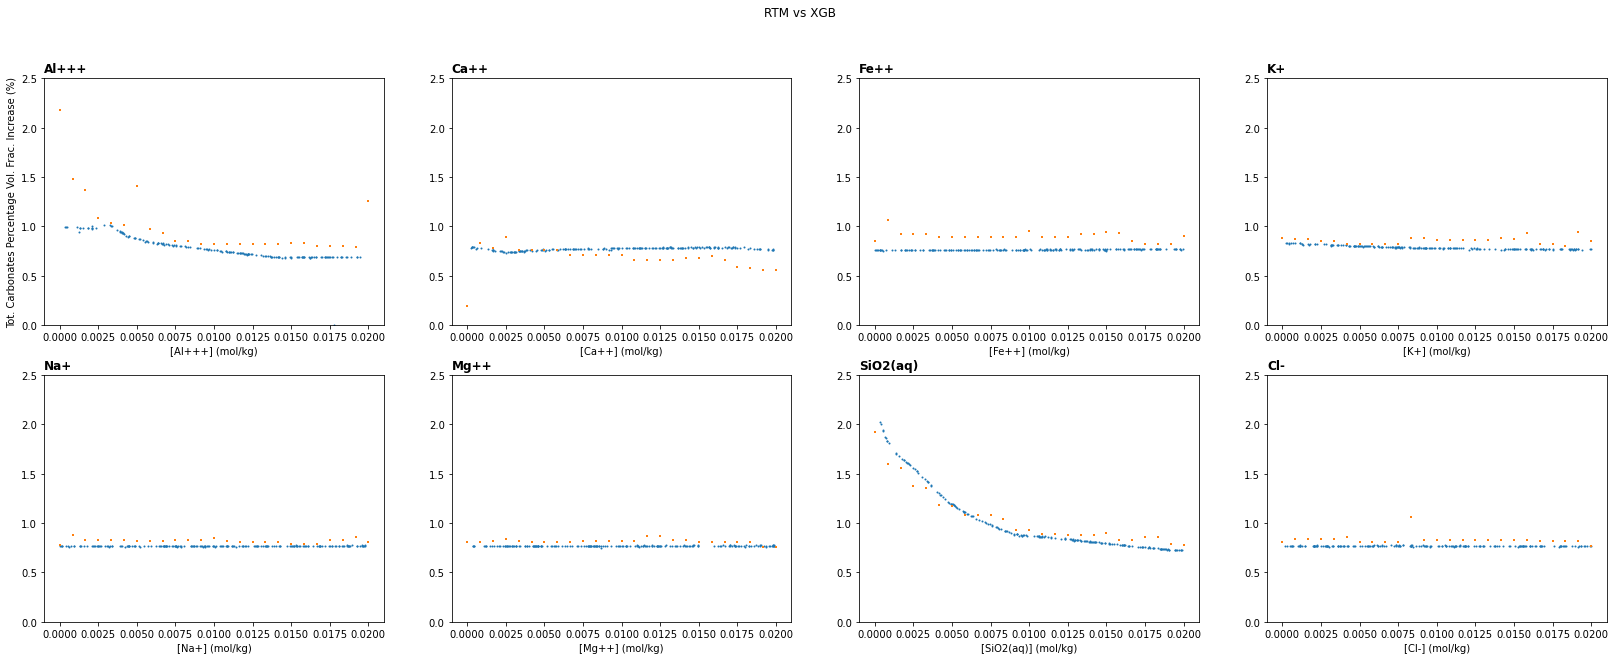

In [23]:
# Plotting the control RTM experiments against predictions made by the XGBoost Model

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

fig.suptitle('RTM vs XGB')

fig.set_figheight(10)
fig.set_figwidth(28)

for attribute_name,axis,x_norm in zip(attribute_names,axes,x_norms):
    axis.set_title(attribute_name, loc='left',fontweight="bold")
    x_truth = dictarray_retriever(attributes_RTMTruth_dict,attribute_name)
    y_truth = dictarray_retriever(target_RTMTruth_dict,attribute_name)
    x_pred = dictarray_retriever(attributes_XGBPred_dict,attribute_name)
    y_pred = dictarray_retriever(target_XGBPred_dict,attribute_name)
    x_truth = x_truth * x_norm
    y_truth = y_truth * y_norm
    x_pred = x_pred * x_norm
    y_pred = y_pred * y_norm
    axis.scatter(x=x_truth, y=y_truth, s=1, alpha=1)
    axis.scatter(x=x_pred, y=y_pred, s=2, alpha=1, marker='+')
    axis.set_xlabel(f'[{attribute_name}] (mol/kg)')
    axis.set_ylim(0, 2.5)

ax1.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')

In [24]:
# Liu's Injection Fluid:
al_conc = 1.19E-3
ca_conc = 1.30E-4
fe_conc = 2.10E-5
k_conc = 2.40E-5
na_conc = 2.04E-3
mg_conc = 1.60E-4
si_conc = 5.90E-4
cl_conc = 1.00E-10

al_conc_upper = 10 * al_conc
ca_conc_upper = 10 * ca_conc
fe_conc_upper = 10 * fe_conc
k_conc_upper = 10 * k_conc
na_conc_upper = 10 * na_conc
mg_conc_upper = 10 * mg_conc
si_conc_upper = 10 * si_conc
cl_conc_upper = 10 * cl_conc

al_conc_lower = al_conc / 10
ca_conc_lower = ca_conc / 10
fe_conc_lower = fe_conc / 10
k_conc_lower = k_conc / 10
na_conc_lower = na_conc / 10
mg_conc_lower = mg_conc / 10
si_conc_lower = si_conc / 10
cl_conc_lower = cl_conc / 10

attribute_names_uppers = [al_conc_upper,ca_conc_upper,fe_conc_upper,k_conc_upper,na_conc_upper,mg_conc_upper,si_conc_upper,cl_conc_upper]
attribute_names_lowers = [al_conc_lower,ca_conc_lower,fe_conc_lower,k_conc_lower,na_conc_lower,mg_conc_lower,si_conc_lower,cl_conc_lower]

Text(0, 0.5, 'Tot. Carbonates Percentage Vol. Frac. Increase (%)')

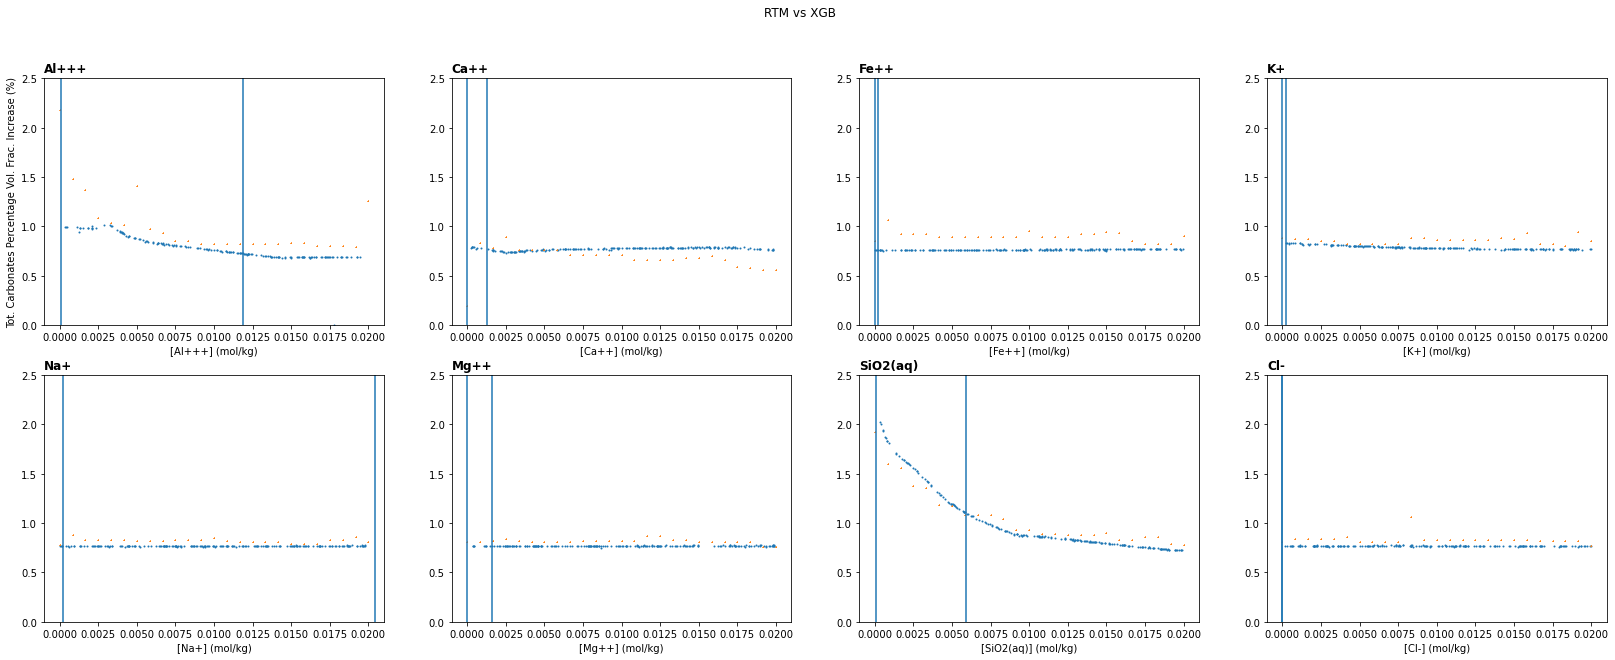

In [25]:
# Plotting the control RTM experiments against predictions made by the XGBoost Model

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

fig.suptitle('RTM vs XGB')

fig.set_figheight(10)
fig.set_figwidth(28)

for attribute_name,axis,x_norm,lower,upper in zip(attribute_names,axes,x_norms,attribute_names_lowers,attribute_names_uppers):
    axis.set_title(attribute_name, loc='left',fontweight="bold")
    x_truth = dictarray_retriever(attributes_RTMTruth_dict,attribute_name)
    y_truth = dictarray_retriever(target_RTMTruth_dict,attribute_name)
    x_pred = dictarray_retriever(attributes_XGBPred_dict,attribute_name)
    y_pred = dictarray_retriever(target_XGBPred_dict,attribute_name)
    x_truth = x_truth * x_norm
    y_truth = y_truth * y_norm
    x_pred = x_pred * x_norm
    y_pred = y_pred * y_norm
    axis.scatter(x=x_truth, y=y_truth, s=1, alpha=1)
    axis.scatter(x=x_pred, y=y_pred, s=1, alpha=1, marker='+')
    axis.set_xlabel(f'[{attribute_name}] (mol/kg)')
    axis.set_ylim(0, 2.5)
    axis.axvline(x=lower)
    axis.axvline(x=upper)

ax1.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')